In [ ]:
from pathlib import Path
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torch.quantization import quantize_dynamic
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the precomputed MFCCs from Google Drive
save_path = '/content/drive/MyDrive/speech_commands_mfccs_aug'
train_data = torch.load(f'{save_path}/train.pt')
val_data = torch.load(f'{save_path}/val.pt')
test_data = torch.load(f'{save_path}/test.pt')

train_mfccs, train_labels = train_data['mfccs'], train_data['labels']
val_mfccs, val_labels = val_data['mfccs'], val_data['labels']
test_mfccs, test_labels = test_data['mfccs'], test_data['labels']

print(f"Train MFCCs shape: {train_mfccs.shape}, Labels shape: {train_labels.shape}")
print(f"Val MFCCs shape: {val_mfccs.shape}, Labels shape: {val_labels.shape}")
print(f"Test MFCCs shape: {test_mfccs.shape}, Labels shape: {test_labels.shape}")

Train MFCCs shape: torch.Size([30769, 113, 20]), Labels shape: torch.Size([30769])
Val MFCCs shape: torch.Size([3703, 101, 20]), Labels shape: torch.Size([3703])
Test MFCCs shape: torch.Size([4074, 101, 20]), Labels shape: torch.Size([4074])


In [ ]:
# Prepare DataLoaders
batch_size = 64
train_dataset = TensorDataset(train_mfccs, train_labels)
val_dataset = TensorDataset(val_mfccs, val_labels)
test_dataset = TensorDataset(test_mfccs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

In [ ]:
# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_size=20, hidden_size=128, num_layers=3, output_size=10, dropout=0.25).to(device)

print(model)

LSTM(
  (lstm): LSTM(20, 128, num_layers=3, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


Epoch [1/200], Train Loss: 1.6094, Train Accuracy: 37.92%, Val Loss: 1.2253, Val Accuracy: 55.79%
Epoch [2/200], Train Loss: 1.0092, Train Accuracy: 64.31%, Val Loss: 0.7797, Val Accuracy: 72.59%
Epoch [3/200], Train Loss: 0.7072, Train Accuracy: 75.59%, Val Loss: 0.6405, Val Accuracy: 79.83%
Epoch [4/200], Train Loss: 0.6005, Train Accuracy: 80.10%, Val Loss: 0.5374, Val Accuracy: 82.39%
Epoch [5/200], Train Loss: 0.4629, Train Accuracy: 84.91%, Val Loss: 0.4006, Val Accuracy: 86.85%
Epoch [6/200], Train Loss: 0.3841, Train Accuracy: 87.27%, Val Loss: 0.3533, Val Accuracy: 88.60%
Epoch [7/200], Train Loss: 0.3303, Train Accuracy: 89.08%, Val Loss: 0.3427, Val Accuracy: 88.82%
Epoch [8/200], Train Loss: 0.2922, Train Accuracy: 90.32%, Val Loss: 0.3180, Val Accuracy: 89.77%
Epoch [9/200], Train Loss: 0.2672, Train Accuracy: 91.15%, Val Loss: 0.3200, Val Accuracy: 89.74%
Epoch [10/200], Train Loss: 0.2388, Train Accuracy: 92.09%, Val Loss: 0.2924, Val Accuracy: 90.95%
Epoch [11/200], Tra

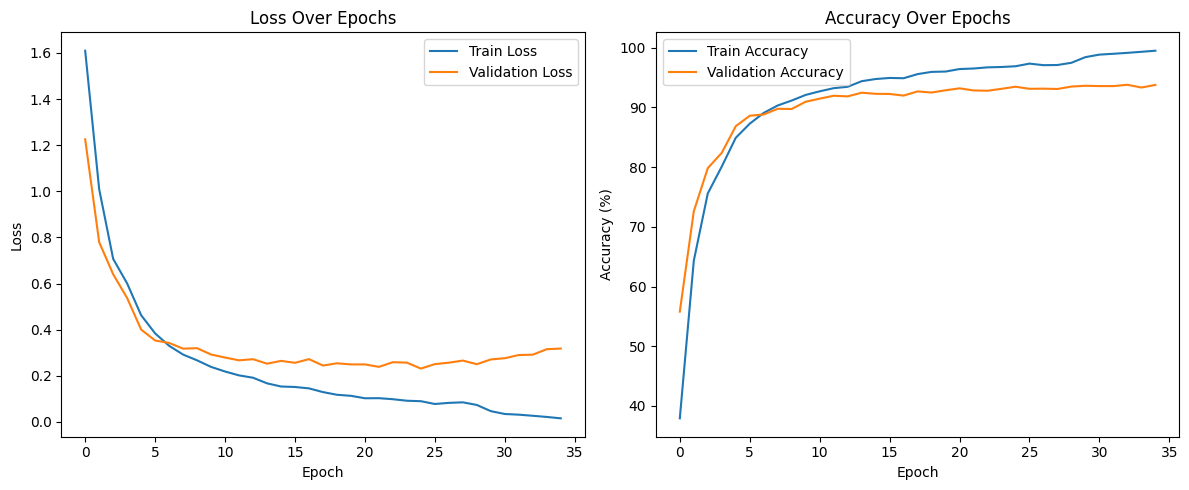

In [ ]:
# Train the model
learning_rate = 0.001
num_epochs = 200
patience = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_loss = float('inf')
early_stop_counter = 0

model_save_path = Path('/content/drive/MyDrive/LSTM')
model_save_path.mkdir(parents=True, exist_ok=True)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for mfccs, labels in train_loader:
        mfccs, labels = mfccs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(mfccs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for mfccs, labels in val_loader:
            mfccs, labels = mfccs.to(device), labels.to(device)
            outputs = model(mfccs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total

    avg_val_loss = val_loss / len(val_loader)
    avg_train_loss = running_loss / len(train_loader)

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), model_save_path / 'LSTM_3L_128HUs_DataAug.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break


# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load the model
model_save_path = Path('/content/drive/MyDrive/LSTM')
model.load_state_dict(torch.load(f'{model_save_path}/LSTM_3L_128HUs_DataAug.pth'))


model.to(device)


# Evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for mfccs, labels in test_loader:
            mfccs, labels = mfccs.to(device), labels.to(device)
            outputs = model(mfccs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

test_accuracy = evaluate_model(model, test_loader, device)
print(f'Model Test Accuracy: {test_accuracy:.2f}%')

Model Test Accuracy: 92.19%


In [ ]:
# Move the model to CPU for quantization
model.to('cpu')

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.LSTM, nn.Linear}, dtype=torch.qint8
)

# Evaluate the quantized model on CPU
test_accuracy = evaluate_model(quantized_model, test_loader, 'cpu')
print(f'Quantized Model Test Accuracy: {test_accuracy:.2f}%')

Quantized Model Test Accuracy: 92.19%


In [ ]:
print(quantized_model)

LSTM(
  (lstm): DynamicQuantizedLSTM(20, 128, num_layers=3, batch_first=True, dropout=0.25)
  (fc): DynamicQuantizedLinear(in_features=128, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)
